# Social Data Analysis and Visualisation Project

## Initialization

### Import Relevant Packages

In [18]:
# import relevant packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import sklearn as sk
import sklearn.preprocessing as prep
import pydotplus
import math 
import plotly.express as px

from scipy import stats
from folium import plugins
from folium.plugins import HeatMapWithTime, MarkerCluster, HeatMap
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.palettes import Category20_14
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

### Initialisation Output Style

In [19]:
# setup bokeh for jupyter notebooks
output_notebook()

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows

# set global plot style
sns.set(style='ticks', palette='muted', color_codes=True)

Loading BokehJS ...

### Load in the Data

In [20]:
cases_data = pd.read_csv("../datasets/cases_by_day.csv", index_col = 0)
# cases_data.columns = pd.to_datetime(cases_data.columns)
deaths_data = pd.read_csv("../datasets/deaths_by_day.csv", index_col = 0)
# deaths_data.columns = pd.to_datetime(deaths_data.columns)
recovered_data = pd.read_csv("../datasets/recovered_by_day.csv", index_col = 0)
# recovered_data.columns = pd.to_datetime(recovered_data.columns)

worldbank_data = pd.read_csv("../datasets/worldbank_and_press_freedom.csv",index_col = 1)
worldbank_data = worldbank_data.rename(columns={ worldbank_data.columns[0]: "country" })
# remove duplicated india row ??
worldbank_data = worldbank_data.drop_duplicates(subset=['country'])
responses_data = pd.read_csv("../datasets/corona_policies_cleaned.csv",index_col = 0)

In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows

## Heat Map Movie

In [26]:
lat_lon_confirmed = pd.read_csv("../datasets/lat_lon_confirmed.csv", index_col = 0)
lat_lon_confirmed = lat_lon_confirmed.reset_index()

In [27]:
# column_names = lat_lon_confirmed.columns
# lat_lon = lat_lon_confirmed.iloc[:,:2]
# max_cases = lat_lon_confirmed.iloc[:,2:].sum()
# lat_lon_confirmed.iloc[:,2:] = lat_lon_confirmed.iloc[:,2:]/max_cases
# lat_lon_confirmed.iloc[:,2:] = lat_lon_confirmed.iloc[:,2:]/lat_lon_confirmed.iloc[:,2:].max().max()
# x = lat_lon_confirmed.iloc[:,2:]
# min_max_scaler = prep.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

# lat_lon_normal = pd.concat([lat_lon, df], axis=1)
# lat_lon_normal.columns = column_names
# lat_lon_normal

listoflists = [] 

for col in lat_lon_confirmed.iloc[:,2:].iteritems():
    col = col[1]
    sublist = []
    for index,row in enumerate(col):
        long = lat_lon_confirmed.Long.iloc[index]
        lat = lat_lon_confirmed.Lat.iloc[index]
        weight = row
        if weight == 0:
            continue
        point = [lat,long,weight]
        sublist.append(point)
    listoflists.append(sublist)

In [28]:
# plot the map
mapmovie = folium.Map(location=[0, 0], zoom_start=1.75, tiles = "Stamen Toner", width = 900, height = 500)

# add the heat map with time
HeatMapWithTime(listoflists).add_to(mapmovie)

# show the movie
mapmovie

## Slider Plot

## Summary Plot

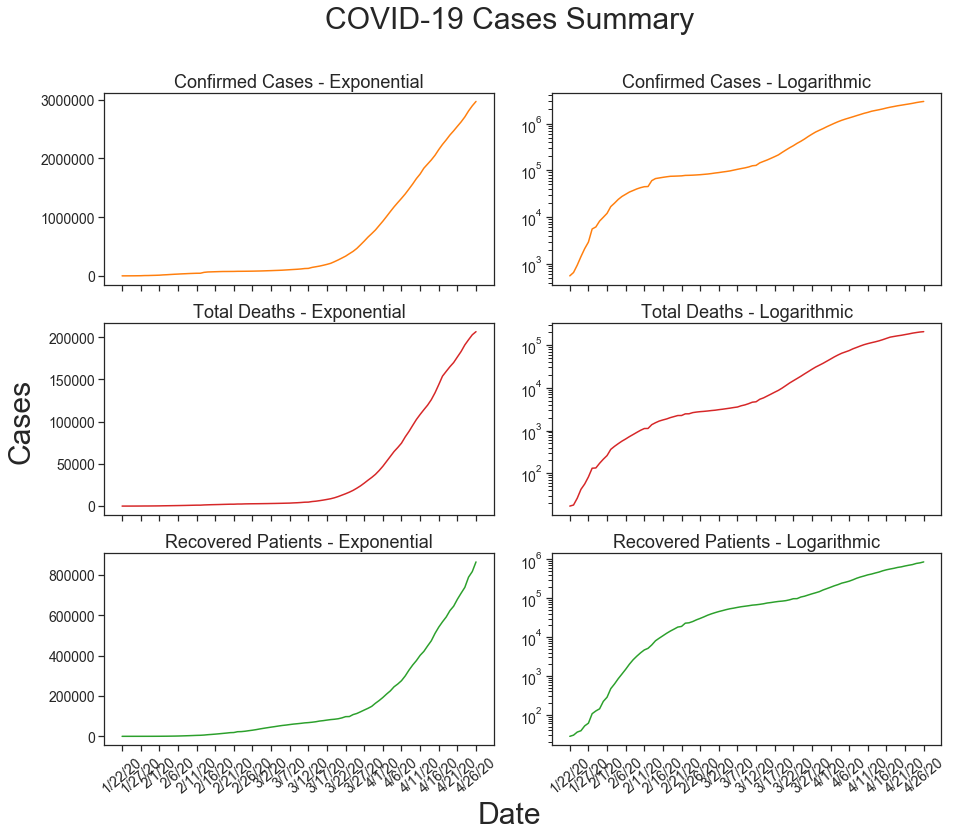

In [29]:
x_ticks = []
i=0
for col in cases_data:
    if(i%5 == 0):
        x_ticks.append(col)
    i = i +1

fig, axs = plt.subplots(3, 2, figsize = (15,12), sharex='col',
                        gridspec_kw={'hspace': 0.2, 'wspace': 0.15})
(ax1, ax2), (ax3, ax4), (ax5, ax6) = axs
fig.suptitle('COVID-19 Cases Summary', fontsize = 30)
ax1.plot(cases_data.columns, cases_data.sum(), 'tab:orange')
ax2.plot(cases_data.columns, cases_data.sum(), 'tab:orange')
ax3.plot(deaths_data.columns, deaths_data.sum(), 'tab:red')
ax4.plot(deaths_data.columns, deaths_data.sum(), 'tab:red')
ax5.plot(recovered_data.columns, recovered_data.sum(), 'tab:green')
ax6.plot(recovered_data.columns, recovered_data.sum(), 'tab:green')

ax1.set(title = "Confirmed Cases - Exponential")
ax2.set(title = "Confirmed Cases - Logarithmic", yscale= "log")
ax3.set(title = "Total Deaths - Exponential")
ax4.set(title = "Total Deaths - Logarithmic", yscale= "log")
ax5.set(title = "Recovered Patients - Exponential")
ax6.set(title = "Recovered Patients - Logarithmic", yscale= "log")

ax1.title.set_size(18)
ax2.title.set_size(18)
ax3.title.set_size(18)
ax4.title.set_size(18)
ax5.title.set_size(18)
ax6.title.set_size(18)

for ax in axs.flat:
    ax.set_xticks(x_ticks)
    ax.tick_params('x', rotation = 40)
    ax.tick_params('y', labelsize ='large')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

fig.text(0.035, 0.5, "Cases", verticalalignment="center", rotation = 90, fontsize = 30);
fig.text(0.5, 0.035, "Date", horizontalalignment="center", rotation = 0, fontsize = 30);

plt.savefig('COVID_Cases_Plot.png')

### Pandemic Curve Plot

In [30]:
# calculate the daily number of active cases
daily_cases_sub_recovered = cases_data.subtract(recovered_data)
daily_cases_data = daily_cases_sub_recovered.subtract(deaths_data)

In [31]:
# initialise focus countries
focus_countries = set(["AUS", "CHN", "DNK", "FRA", "IND", "IRN", "ITA", "MEX", "SWE", "USA"])

# separate the focus countries from the data
data_focused = daily_cases_data.loc[focus_countries]
data_focused = data_focused.T
data_focused

country_code,IRN,AUS,ITA,IND,CHN,MEX,FRA,USA,DNK,SWE
1/22/20,0.0,0.0,0.0,0.0,502.0,0.0,0.0,1.0,0.0,0.0
1/23/20,0.0,0.0,0.0,0.0,591.0,0.0,0.0,1.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,854.0,0.0,2.0,2.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,1318.0,0.0,3.0,2.0,0.0,0.0
1/26/20,0.0,4.0,0.0,0.0,1957.0,0.0,3.0,5.0,0.0,0.0
1/27/20,0.0,5.0,0.0,0.0,2723.0,0.0,3.0,5.0,0.0,0.0
1/28/20,0.0,5.0,0.0,0.0,5262.0,0.0,4.0,5.0,0.0,0.0
1/29/20,0.0,6.0,0.0,0.0,5817.0,0.0,5.0,5.0,0.0,0.0
1/30/20,0.0,7.0,0.0,1.0,7818.0,0.0,5.0,5.0,0.0,0.0
1/31/20,0.0,7.0,2.0,1.0,9356.0,0.0,5.0,7.0,0.0,1.0


Divide daily cases by population size to allow to truly compare countries:

In [32]:
pops = worldbank_data.loc[focus_countries,'population']
norm_data = data_focused/pops
norm_data

country_code,IRN,AUS,ITA,IND,CHN,MEX,FRA,USA,DNK,SWE
1/22/20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.604432e-07,0.000000e+00,0.000000e+00,3.056539e-09,0.000000e+00,0.000000e+00
1/23/20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.243464e-07,0.000000e+00,0.000000e+00,3.056539e-09,0.000000e+00,0.000000e+00
1/24/20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.131842e-07,0.000000e+00,2.985643e-08,6.113078e-09,0.000000e+00,0.000000e+00
1/25/20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.463428e-07,0.000000e+00,4.478465e-08,6.113078e-09,0.000000e+00,0.000000e+00
1/26/20,0.000000e+00,1.600489e-07,0.000000e+00,0.000000e+00,1.405154e-06,0.000000e+00,4.478465e-08,1.528269e-08,0.000000e+00,0.000000e+00
1/27/20,0.000000e+00,2.000611e-07,0.000000e+00,0.000000e+00,1.955153e-06,0.000000e+00,4.478465e-08,1.528269e-08,0.000000e+00,0.000000e+00
1/28/20,0.000000e+00,2.000611e-07,0.000000e+00,0.000000e+00,3.778191e-06,0.000000e+00,5.971286e-08,1.528269e-08,0.000000e+00,0.000000e+00
1/29/20,0.000000e+00,2.400733e-07,0.000000e+00,0.000000e+00,4.176689e-06,0.000000e+00,7.464108e-08,1.528269e-08,0.000000e+00,0.000000e+00
1/30/20,0.000000e+00,2.800855e-07,0.000000e+00,7.393074e-10,5.613435e-06,0.000000e+00,7.464108e-08,1.528269e-08,0.000000e+00,0.000000e+00
1/31/20,0.000000e+00,2.800855e-07,3.309544e-08,7.393074e-10,6.717741e-06,0.000000e+00,7.464108e-08,2.139577e-08,0.000000e+00,9.820120e-08


In [33]:
# convert the Pandas Dataframe to Bokeh ColumnDataSource
source = ColumnDataSource(norm_data)

# intialise a string of x range values, in this case, hours of the day
hours = [str(i) for i in norm_data.index.values]

# create a new figure, specify the x_range, plot_width and title
p = figure(x_range=FactorRange(*hours),plot_width=1000, 
           title = "Pandemic Curve")

# to store vbars
bar = {}

# loop through each of the focus_countries
for i,category in enumerate(focus_countries):
    # create a vbar for each focus_countries
    bar[category] = p.vbar(width=0.5, alpha=0.5, x="index", top=category, 
        source=source, muted_alpha=0.05, muted=True,
        color=Category20_14[i]) 

# add a legend to the plot
legend_items = [(i,[bar[i]]) for i in focus_countries]
legend = Legend(items=legend_items, location=(0,110),click_policy="mute")
p.add_layout(legend,'left')

# add trimmings to the plot and adjust font sizes
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Relative Frequency"
p.title.text_font_size = '24pt'
p.xaxis.axis_label_text_font_size = '14pt'
p.yaxis.axis_label_text_font_size = '14pt'
p.xaxis.major_label_orientation = math.pi/3 

show(p)

### Interactive Plot 1: Government Measures

In [32]:
new_df = pd.DataFrame(index=cases_data.index)
firstday_dates = pd.Series(pd.to_datetime(['22/01/2020'])).repeat(len(new_df))
new_df = new_df.assign(initial_day=firstday_dates.values)
new_df = new_df.assign(days_before_first_case = firstdays)

In [33]:
# Add column with the date of the first case
initial_dates = []
for row in new_df.iterrows():
#     print("row: {}".format(row))
    initial_dates.append(row[1].initial_day + pd.DateOffset(days=row[1].days_before_first_case))
new_df = new_df.assign(first_case_date = initial_dates)

In [34]:
responses_relevant = responses_data.drop(columns= ['COMMENTS','NON_COMPLIANCE','SOURCE','SOURCE_TYPE','LINK', 'Alternative source', 'ENTRY_DATE'])

In [35]:
responses_notna = responses_relevant.dropna(subset=['DATE_IMPLEMENTED'])

In [36]:
responses_notna['DATE_IMPLEMENTED'] = pd.to_datetime(responses_notna['DATE_IMPLEMENTED'], format='%d/%m/%Y')

ValueError: time data '2020-02-12' does not match format '%d/%m/%Y' (match)

In [29]:
first_ever_measure_dates = {}
first_ever_measure_types = {}
for iso in responses_notna.ISO.unique():
    subset = responses_notna[responses_notna.ISO == iso]
    first_ever_measure_dates.update({iso: subset.DATE_IMPLEMENTED.min()})
    first_ever_measure_types.update({iso: subset.loc[subset.DATE_IMPLEMENTED.idxmin()].CATEGORY})

new_df["first_measure_date"] = np.nan
new_df["first_measure_type"] = np.nan

for iso in first_ever_measure_dates:
    try:
        new_df.loc[iso, 'first_measure_date'] = first_ever_measure_dates[iso]
    except KeyError:
        print('Error: ISO code {} not present in dataframe.'.format(iso))
    
for iso in first_ever_measure_types:
    try:
        measure_type = first_ever_measure_types[iso]
        
        new_df.loc[iso, 'first_measure_type'] = str(first_ever_measure_types[iso])
    except KeyError:
        print('Error: ISO code {} not present in dataframe.'.format(iso))

no_nans = new_df.dropna()        
no_nans['first_measure_date'] = pd.to_datetime(no_nans.first_measure_date)
time_before_first_measure = no_nans['first_measure_date'] - no_nans['first_case_date']
no_nans = no_nans.assign(time_before_first_measure = time_before_first_measure.dt.days)
full_data = no_nans.merge(worldbank_data, left_index=True, how='left',right_index=True)
fig = px.scatter(data_frame=full_data,y = "time_before_first_measure",x ='days_before_first_case', hover_name=full_data.index, color=  'first_measure_type')


cases_and_measures = new_df.merge(responses_notna,left_index=True,right_on = 'ISO',how='right' )
cases_and_measures_nona = cases_and_measures.dropna()
unique_measures= list(cases_and_measures_nona.MEASURE.unique())
unique_measures.sort()
cases_and_measures.loc[:,'MEASURE'] = cases_and_measures.loc[:,'MEASURE'].apply(lambda x: x.replace('\xa0',''))
cases_and_measures = cases_and_measures.assign( implementation_after_pandemic = (cases_and_measures.DATE_IMPLEMENTED - cases_and_measures.initial_day).dt.days)
cases_and_measures = cases_and_measures.assign( implementation_after_case_in_country = (cases_and_measures.DATE_IMPLEMENTED - cases_and_measures.first_case_date).dt.days)

full_data = cases_and_measures.merge(worldbank_data, left_on='ISO', right_index=True, how='left')
fig =  px.scatter(full_data, color='CATEGORY', x = 'implementation_after_pandemic', y ='freedom_score', hover_name='COUNTRY',hover_data = ['MEASURE'] )
# fig.show()

codes = full_data.index.unique()
lockdowns= full_data[full_data.CATEGORY == 'Lockdown']
lockdowns = lockdowns.sort_values(by='DATE_IMPLEMENTED')
lockdowns_unique = lockdowns.drop_duplicates(subset = ['ISO'],keep='first')
cases_on_lockdown = []
for index,row in lockdowns_unique.iterrows():
    cases_on_lockdown.append(cases_data.loc[row.index,row.DATE_IMPLEMENTED])
lockdowns_with_cases = lockdowns_unique.assign(cases_on_lockdown = cases_on_lockdown)
lockdowns_with_cases = lockdowns_with_cases.dropna(subset=['hospital_beds_per_1000'])

px.scatter(
    data_frame=lockdowns_with_cases,
    x = lockdowns_with_cases.implementation_after_case_in_country,
    y ='cases_on_lockdown',
    log_y = True, 
#     size= "health_expenditure_per_capita", 
    color='hospital_beds_per_1000',
    color_continuous_midpoint=3,
    hover_name='COUNTRY',
    marginal_x='histogram')

C:\Users\betha\Anaconda3\envs\dataviz\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: (nan, '', '', '', '')

### Healthcare Expenditure

In [34]:
# indicator_data = worldbank_data[["gdp_per_capita", "universal_healthcare_coverage_index", "hospital_beds_per_1000", "physicians_per_1000", "health_expenditure_per_capita", "government_effectiveness", "political_stability"]]
plot_data = worldbank_data.loc[:,["gdp_per_capita", "health_expenditure_per_capita","population"]]
plot_data = plot_data.drop('SMR')
country_sum = cases_data.iloc[:,-1]
plot_data = plot_data.assign(cases = country_sum)
plot_data = plot_data.assign(cases_per_capita = plot_data.cases/plot_data.population)
data_complete = plot_data.dropna()

In [35]:
source = ColumnDataSource(data_complete)


TOOLTIPS = [
    ("Country", "@country_code"),
#     ("(x,y)", "($x, $y)"),
#     ("desc", "@desc"),
]

gdp_plot = figure(tooltips=TOOLTIPS)
health_plot = figure(tooltips=TOOLTIPS)
plots = [gdp_plot,health_plot]
indicators = ['gdp_per_capita','health_expenditure_per_capita']
for plot, indicator in zip(plots,indicators):
    plot.circle(x=indicator,y='cases_per_capita',source=source,size = 5)
    
    X = data_complete[indicator].values.reshape(-1, 1)
    y = data_complete.cases_per_capita
    reg = LinearRegression().fit(X,y)
    y_predicted = reg.predict(data_complete[indicator].values.reshape(-1,1))
    score = reg.score(X,y)
    plot.line(data_complete[indicator],y_predicted,color='red', legend_label="R^2: {}".format(score))
    plot.xaxis.axis_label = indicator
    plot.yaxis.axis_label = "Cases (adjusted by population)"
    plot.title.text_font_size = '24pt'
    plot.xaxis.axis_label_text_font_size = '14pt'
    plot.yaxis.axis_label_text_font_size = '14pt'
    plot.xaxis.major_label_orientation = math.pi/3 
    
    # show(p)
show(row(plots))

# Let's try multiple regression to see if we get a better fit!

X = data_complete[indicators].values
y = data_complete.cases_per_capita.values
regression = LinearRegression().fit(X,y)
print("R-square for multiple regression on both GDP and health expendigure: {}. This is slightly better whan with just the GDP.".format(regression.score(X,y)))

TypeError: 'int' object is not callable

## Interactive Plot 2: Healthcare System (bubble chart, animated?)

## Political State (government effectiveness & political stability VS. rate of increase?)

## Stringency Measures Plot (similar to Oxford University Visualisation) (interactive)

## Stringency vs. Number of Coronavirus Cases (include linear regression line)

## Epidemic curve + stringency measure (bar plot identical to the 'epidemic curve', where the color represents stringency level)